In [ ]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

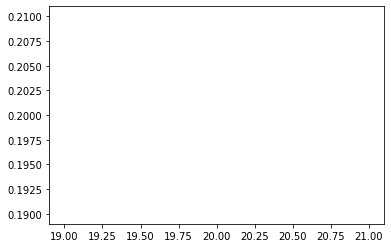

In [ ]:
show_plot(20,.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class Config():
    train_batch_size = 50
    train_number_epochs = 100 

In [ ]:
!cp -r "/content/drive/My Drive/Dataset/Mini1" .

In [ ]:
ls

drive/  Mini1/  sample_data/


In [ ]:
!ls /content/Mini1

test  test.csv	train  train.csv


In [ ]:
training_dir="/content/Mini1/train"
training_csv="/content/Mini1/train.csv"
testing_csv="/content/Mini1/test.csv"
testing_dir="/content/Mini1/test"

In [ ]:
training_dir="/content/drive/My Drive/Dataset1/Resize_FGNET_CSV/Re_Size"
training_csv="/content/drive/My Drive/Dataset1/Resize_FGNET_CSV/Re_Size/Train.csv"
testing_csv="/content/drive/My Drive/Dataset1/Resize_FGNET_CSV/Re_Size/Test.csv"
testing_dir="/content/drive/My Drive/Dataset1/Resize_FGNET_CSV/Re_Size"

In [ ]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

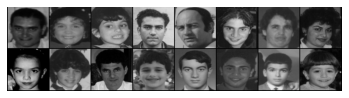

[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
           # nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
          # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            #nn.Linear(1024, 128),
           # nn.ReLU(inplace=True),
            
            nn.Linear(256,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [ ]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i % 10 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
#show_plot(counter,loss_history)
torch.save(model.state_dict(), "/content/model.pt")
print("Model Saved Successfully")

Streaming output truncated to the last 5000 lines.
Epoch number 38
 Current loss 1.2197728157043457

Epoch number 38
 Current loss 1.0467114448547363

Epoch number 38
 Current loss 1.4715040922164917

Epoch number 38
 Current loss 1.2507505416870117

Epoch number 38
 Current loss 1.2198923826217651

Epoch number 38
 Current loss 1.2867950201034546

Epoch number 38
 Current loss 1.261945128440857

Epoch number 38
 Current loss 1.2220921516418457

Epoch number 38
 Current loss 1.0841636657714844

Epoch number 38
 Current loss 1.2113529443740845

Epoch number 38
 Current loss 1.1867201328277588

Epoch number 38
 Current loss 1.3200894594192505

Epoch number 38
 Current loss 1.206514835357666

Epoch number 38
 Current loss 1.2069429159164429

Epoch number 38
 Current loss 1.281437635421753

Epoch number 38
 Current loss 1.2504864931106567

Epoch number 38
 Current loss 1.266701579093933

Epoch number 38
 Current loss 1.271357774734497

Epoch number 38
 Current loss 1.2028237581253052

Epoc

In [ ]:
print(model)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.3, inplace=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=30976, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Linear(in_feat

In [ ]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
#print(model)
model.load_state_dict(torch.load("/content/model.pt"))

<All keys matched successfully>

In [ ]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

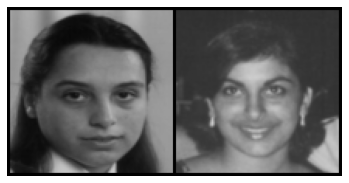

Similarity Score = tensor([0.5215], device='cuda:0', grad_fn=<AbsBackward>)
It is Similar person


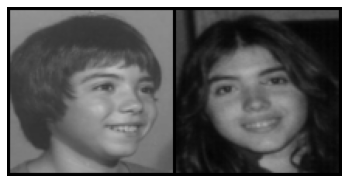

Similarity Score = tensor([0.1634], device='cuda:0', grad_fn=<AbsBackward>)
It is Dissimilar person


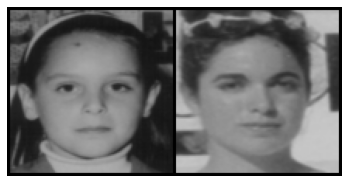

Similarity Score = tensor([0.1754], device='cuda:0', grad_fn=<AbsBackward>)
It is Similar person


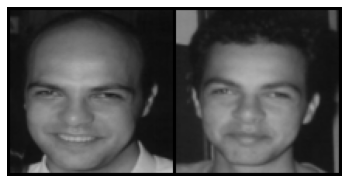

Similarity Score = tensor([0.7082], device='cuda:0', grad_fn=<AbsBackward>)
It is Dissimilar person


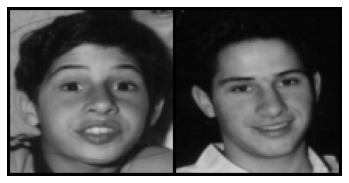

Similarity Score = tensor([0.5295], device='cuda:0', grad_fn=<AbsBackward>)
It is Dissimilar person


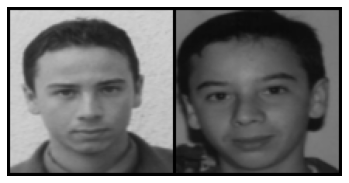

Similarity Score = tensor([0.7290], device='cuda:0', grad_fn=<AbsBackward>)
It is Dissimilar person


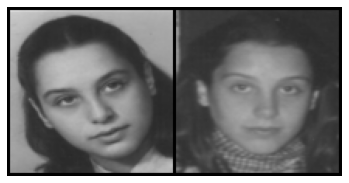

Similarity Score = tensor([0.0954], device='cuda:0', grad_fn=<AbsBackward>)
It is Dissimilar person


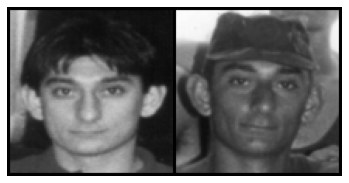

Similarity Score = tensor([0.6803], device='cuda:0', grad_fn=<AbsBackward>)
It is Dissimilar person


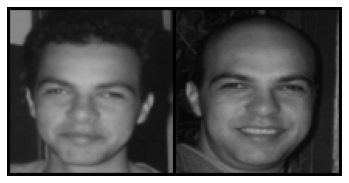

Similarity Score = tensor([0.5011], device='cuda:0', grad_fn=<AbsBackward>)
It is Dissimilar person


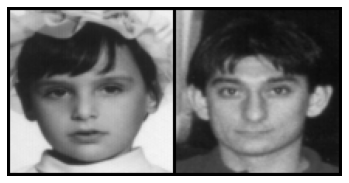

Similarity Score = tensor([0.5315], device='cuda:0', grad_fn=<AbsBackward>)
It is Similar person


In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Similar"
  else:
    label="Dissimilar"
  imshow(torchvision.utils.make_grid(concatenated))
  sim=abs(1-eucledian_distance)
  print("Similarity Score =", sim)
  print("It is " + label + " person")
  #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==10:
     break

In [ ]:
test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
accuracy=0
counter=0
correct=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = model(x0.to(device),x1.to(device))
  #print(output1)
  res=torch.abs(output1.cuda() - output2.cuda())
  #print('hi')
 # print(res)
  label=label[0].tolist()
  label=int(label[0])
  result=torch.max(res,1)[1].data[0].tolist()
  if label == result:
    correct=correct+1
  counter=counter+1
  if counter ==4000:
   break
    
accuracy=(correct/len(test_dataloader))*100
print("Accuracy:{}%".format(accuracy))

Accuracy:49.88558352402746%
